# Gaussian Processes algorithms for time series in the fashion B2B sector (second family of product.)

### Code and report developed by Javier Saez for Textil Santanderina.

<img src=https://textilsantanderina.com/wp-content/uploads/2021/02/cropped-gliphicon-512x512-1.png width=150 height=50 />


## Summary:


1. [Predicting year 2020 + 2021 values with monthly time series.](#id1)
1. [Predicting year 2020 + 2021 values with weekly time series.](#id2)
1. [Last comments and recommendations regarding exogenous factors.](#id3)

**Key points before starting:**

* I would like to point our best predictor performance to be improved: an average error per observation of 171 thousand €.

* We divide our target and features by 1e3 to tall about thousand of euros.

* Gaussian Processes give us an confidence interval, to know how likely are our predictions to be true (from there comes the concept Likelihood in Bayesian statistics), we consider this could be a very interesting experiment for firms due to it gives as ranges of values instead of a especific prediction, because from there it is easier to take strategic decisions from the business point of view.
* In Gaussian Processes our parameter to maximize is the log marginal Likelihood, which wil be used as a criteria to make a choise between GP with monthly data or weekly data (more observations to learn from but with more variance).


$\nabla_{\theta} L\left(\theta ;\left(y_{i}, x_{i}\right)\right)=0(\text { máximo })$


$l=-\log \left(L\left(\theta ;\left(y_{i}, x_{i}\right)\right)\right)=-\sum_{j} \log \left(\operatorname{pd} f\left(y_{i} \mid x_{i}\right) ; \theta\right)$



In [1]:
## required regular libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## required kernel and GP libraries:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from time import time

## 1. Predicting year 2020 + 2021 values with monthly time series.<a name="id1"></a>

In [3]:
## relative path to the processed data:
os.chdir("../../../../../data/processed")

In [11]:
y = pd.read_pickle("time_serie_y_total_production_2_monthly.pkl")
x = pd.read_pickle("time_serie_x_total_production_2_monthly.pkl")

Let's see the the standar deviation of the sample to compare in the future:

In [12]:
y.target[0:12].std()

664526.5368654513

In [13]:
X = np.asarray(x.time).reshape(-1, 1)
y = np.asarray(y.target).reshape(-1,1)/1e3

Here we have again our monthly time series, we see it has sesonal component and a decreasing tendency (at least in the years we are observing):

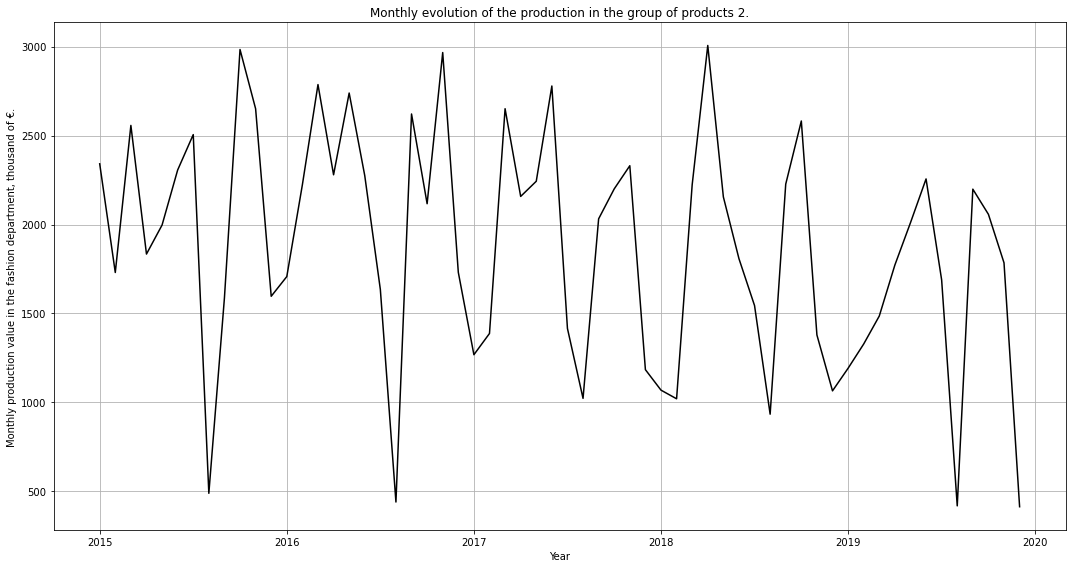

In [14]:
fig = plt.figure(figsize=(15,8))
plt.plot(X, y, c='k')
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"Monthly production value in the fashion department, thousand of €.")
plt.title(r"Monthly evolution of the production in the group of products 2.")
plt.tight_layout()
plt.show()

In [16]:

# Kernel with random parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

#optimizing parameters:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True,
                              n_restarts_optimizer=1,
                              random_state=0)


t0 = time()
gp.fit(X, y)
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 2,84)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

Elapsed time: 0.905s

Learned kernel: 3.16**2 * RBF(length_scale=21.4) + 3.16**2 * RBF(length_scale=14.7) * ExpSineSquared(length_scale=0.982, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=0.841, length_scale=5.22) + 0.48**2 * RBF(length_scale=0.0112) + WhiteKernel(noise_level=0.132)
Log-marginal-likelihood: -74.442


In [17]:
y_pred = y_pred.reshape(-1)

After optimizing our parameters for the GP it is ease to see that it performed well, all our actual points are inside our intervals: 

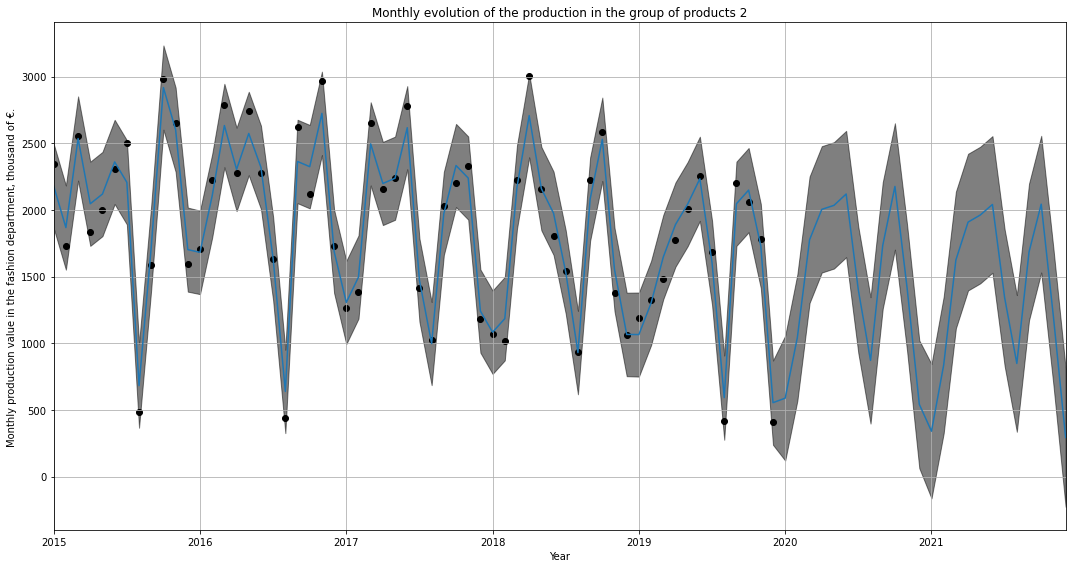

In [18]:
# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"Monthly production value in the fashion department, thousand of €.")
plt.title(r"Monthly evolution of the production in the group of products 2")
plt.tight_layout()
plt.show()

In [19]:
gp.log_marginal_likelihood(gp.kernel_.theta)

-74.4420848659067

## 2. Predicting year 2020 + 2021 values with weekly time series.<a name="id2"></a>

In [20]:
y = pd.read_pickle("time_serie_y_total_production_2_weekly.pkl")
x = pd.read_pickle("time_serie_x_total_production_2_weekly.pkl")

We see a higher variance here even though we have the same sample but in this case separated into weeks instead of in months.

In [21]:
y.target[0:12].std()

254749.9199612665

In [19]:
X = np.asarray(x.time).reshape(-1, 1)
y = np.asarray(y.target).reshape(-1,1)/1e3

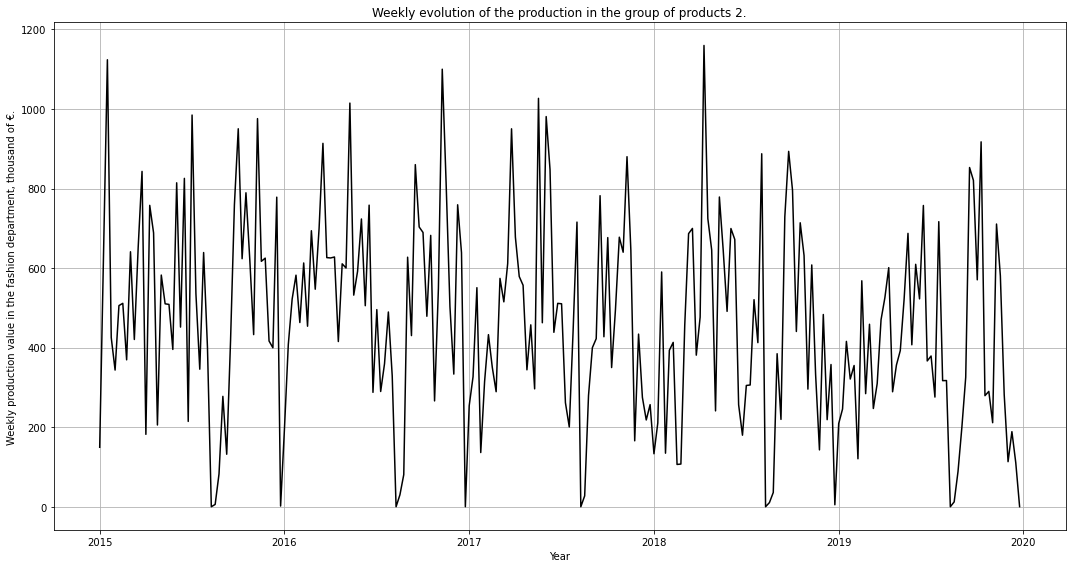

In [20]:
fig = plt.figure(figsize=(15,8))
plt.plot(X, y, c='k')
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"Weekly production value in the fashion department, thousand of €.")
plt.title(r"Weekly evolution of the production in the group of products 2.")
plt.tight_layout()
plt.show()

In [22]:
# Kernel with random parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

#optimizing parameters:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True,
                              n_restarts_optimizer=1,
                              random_state=0)


t0 = time()
gp.fit(X, y)
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max()+2,336)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

Elapsed time: 5.497s

Learned kernel: 3.16**2 * RBF(length_scale=3.61e+03) + 3.16**2 * RBF(length_scale=34.4) * ExpSineSquared(length_scale=0.544, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=5.63, length_scale=263) + 0.646**2 * RBF(length_scale=5.24) + WhiteKernel(noise_level=0.602)
Log-marginal-likelihood: -312.449


In [23]:
y_pred = y_pred.reshape(-1)

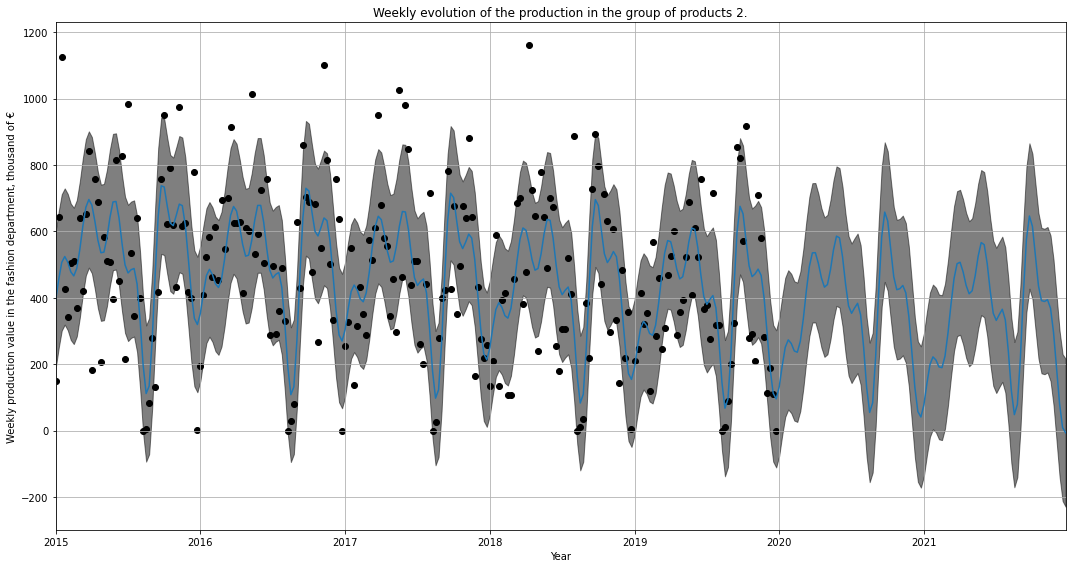

In [24]:
# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"Weekly production value in the fashion department, thousand of €")
plt.title(r"Weekly evolution of the production in the group of products 2.")
plt.tight_layout()
plt.show()

We see a worst value for our logaritmic marginal Likelihood, then we prefer to use for this model our monthly time series even thoug we divide by four our number of observations to fit our model: 

In [25]:
gp.log_marginal_likelihood(gp.kernel_.theta)

-312.4493399154626

## 3. Last comments and recommendations regarding exogenous factors.<a name="id2"></a>

Now we have to compare our results with our best predictor model till now Random Forest for Regression with an average error of 171  thousand € per week (or 684  thousand € per month).

Then we can compare the precision using a common error estiamtor like RMSE (we lose our intervarls created by Bayesian inference here).

**Aditional Key point before starting this sub-experience:**

* Now we need to use again 2019 as test year, thus we need to split our data and optimize again to avoid data leak issues.

In [81]:
y = pd.read_pickle("time_serie_y_total_production_2_monthly.pkl")
x = pd.read_pickle("time_serie_x_total_production_2_monthly.pkl")

last_month_2018 = 48
last_month_2019 = 60

y_Test = np.asarray(y.target[last_month_2018:last_month_2019]/1e3).reshape(-1,1)
y_Train = np.asarray(y.target[0:last_month_2018]/1e3).reshape(-1,1)

X_Test = np.asarray(x.time[last_month_2018:last_month_2019]).reshape(-1,1)
X_Train = np.asarray(x.time[0:last_month_2018]).reshape(-1,1)

In [82]:
# Kernel with random parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

#optimizing parameters:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True,
                              n_restarts_optimizer=1,
                              random_state=0)


t0 = time()
gp.fit(X_Train, y_Train)
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X_Train.min(), X_Train.max() + 1,60)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)
y_pred = y_pred.reshape(-1)

Elapsed time: 0.542s

Learned kernel: 3.16**2 * RBF(length_scale=1e+05) + 3.16**2 * RBF(length_scale=8.83) * ExpSineSquared(length_scale=0.951, periodicity=1) + 0.1**2 * RationalQuadratic(alpha=0.732, length_scale=1e+03) + 0.476**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.141)
Log-marginal-likelihood: -63.177


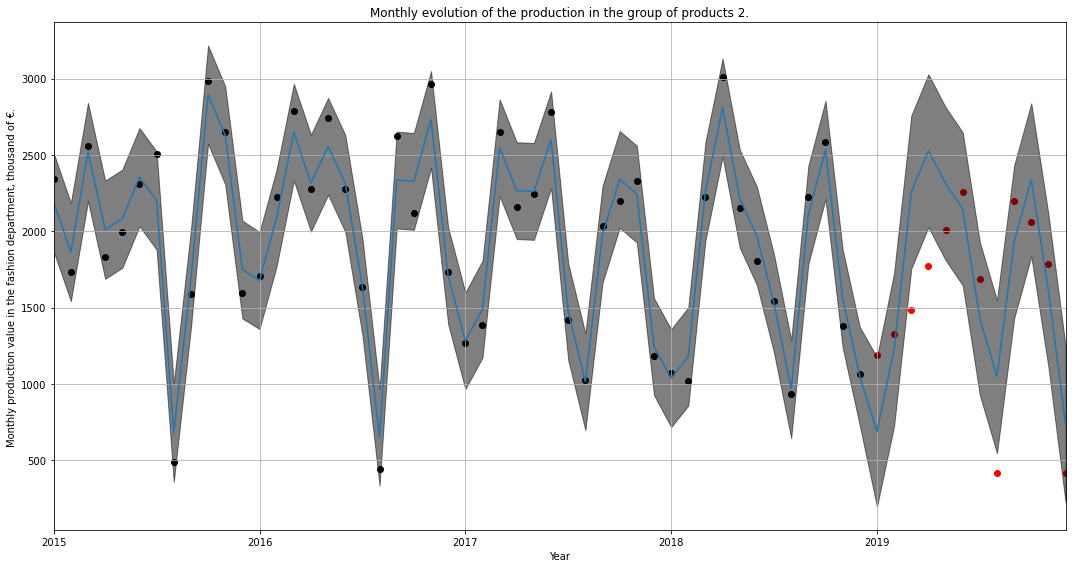

In [83]:
# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(X_Train, y_Train, c='k')
plt.scatter(X_Test, y_Test, c='r')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"Monthly production value in the fashion department, thousand of €.")
plt.title(r"Monthly evolution of the production in the group of products 2.")
plt.tight_layout()
plt.show()

In [79]:
## libraries regarding the metrics we want to use:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


## our predictions:
y_pred = y_pred[-12:]
print("Mean error in test is "+str(np.round(mean_squared_error(y_true= y_Test, y_pred=y_pred, squared=False),2))+" thousand € average error per month or "+str(round(mean_squared_error(y_true= y_Test, y_pred=y_pred, squared=False)/4,2))+" thousand € per week.")
print("We see also that our model explains the casuality of the target variable in a "+str(round(1e2*r2_score(y_true= y_Test, y_pred=y_pred),2))+"%.")

Mean error in test is 435.8 thousand € average error per month or 108.95 thousand € per week.
We see also that our model explains the casuality of the target variable in a 46.59%.


Finally, we see that we  break our last record (mean error of 171 thousand €) with this non-featured model, but a good amount of casuality explained has been lost.

| Model | R${^2}$ | RMSE |
| --- | --- | --- |
| EMA last year (base line predictor) | --- | 211 thousand €/week|
| Lineal Model | 14% | 208 thousand €/week
| KNN | 8% | 215 thousand €/week |
| RFR | 63.5% | 171 thousand €/week |
| GPR | 46.59% | 109 thousand €/week |

**Key points of this result and the problem of exogenous factors:**

* We still can make future improvements with parameter optimizations.

* With 2020 business-year it is hard  to know whether it would still have good results due to exogenous elements like the global pandemic of COVID-19.